# Climate indicator forecasts over Vanuatu using CMIP6 data

## Marine heat wave future projections

In this tutorial, we'll cover the following:
- Select CMIP6 `tos` product based on SSP scenario
- Load sea surface temperature (`tos`) climate variable
- Calculate marine heat wave climate indice based on multi-variate data

In [1]:
# !mamba uninstall -y odc-loader
# !mamba install -y cartopy obstore 'zarr>=3' 'python=3.11'

In [2]:
import cartopy.crs as ccrs
import dask.diagnostics
import matplotlib.pyplot as plt
import obstore
import pandas as pd
import xarray as xr
import xclim
import zarr

## Part 1: Getting cloud hosted CMIP6 data

The [Coupled Model Intercomparison Project Phase 6 (CMIP6)](https://en.wikipedia.org/wiki/CMIP6#CMIP_Phase_6)
dataset is a rich archive of modelling experiments carried out to predict the climate change impacts.
The datasets are stored using the [Zarr](https://zarr.dev) format, and we'll go over how to access it.

**Note**: This section was adapted from https://tutorial.xarray.dev/intermediate/remote_data/cmip6-cloud.html

Sources:
- https://esgf-node.llnl.gov/search/cmip6/
- CMIP6 data hosted on Google Cloud - https://console.cloud.google.com/marketplace/details/noaa-public/cmip6
- Pangeo/ESGF Cloud Data Access tutorial - https://pangeo-data.github.io/pangeo-cmip6-cloud/accessing_data.html

In [3]:
df = pd.read_csv("https://cmip6.storage.googleapis.com/pangeo-cmip6.csv")
print(f"Number of rows: {len(df)}")

Number of rows: 514818


Over 500,000 rows! Let's filter it down to the variable and experiment
we're interested in, e.g. sea surface temperature.

For the `variable_id`, you can look it up given some keyword at
https://docs.google.com/spreadsheets/d/1UUtoz6Ofyjlpx5LdqhKcwHFz2SGoTQV2_yekHyMfL9Y

For the `table_id`, we will filter to just 'Oday' for daily measurements.

Another good place to find the right model runs is https://esgf-node.llnl.gov/search/cmip6
(once you get your head around the acronyms and short names).

Below, we'll filter to CMIP6 experiments matching:
- Sea Surface Temperature [degC] (variable_id: `tos`)
- Daily measurements (table_id: `Oday`)
- Institution from Beijing Climate Center (institution_id: 'BCC') which is known to have higher resolution ocean models (50km)

References:
- Dhage, L., & Widlansky, M. J. (2022). Assessment of 21st Century Changing Sea Surface Temperature, Rainfall, and Sea Surface Height Patterns in the Tropical Pacific Islands Using CMIP6 Greenhouse Warming Projections. Earth’s Future, 10(4), e2021EF002524. https://doi.org/10.1029/2021EF002524

In [4]:
df_tos = df.query("variable_id == 'tos' & table_id == 'Oday' & institution_id == 'BCC'")
df_tos.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
41139,CMIP,BCC,BCC-CSM2-MR,historical,r2i1p1f1,Oday,tos,gn,gs://cmip6/CMIP6/CMIP/BCC/BCC-CSM2-MR/historic...,NaN,20181031
41290,CMIP,BCC,BCC-CSM2-MR,historical,r3i1p1f1,Oday,tos,gn,gs://cmip6/CMIP6/CMIP/BCC/BCC-CSM2-MR/historic...,NaN,20181102
43160,CMIP,BCC,BCC-CSM2-MR,historical,r1i1p1f1,Oday,tos,gn,gs://cmip6/CMIP6/CMIP/BCC/BCC-CSM2-MR/historic...,NaN,20181126
45066,CMIP,BCC,BCC-ESM1,historical,r1i1p1f1,Oday,tos,gn,gs://cmip6/CMIP6/CMIP/BCC/BCC-ESM1/historical/...,NaN,20181218
45250,CMIP,BCC,BCC-ESM1,historical,r2i1p1f1,Oday,tos,gn,gs://cmip6/CMIP6/CMIP/BCC/BCC-ESM1/historical/...,NaN,20181218


## Part 2: Choose SSP scenario and read from Zarr store

Now to choose a shared socio-economic pathway (SSP) scenario.
These are the possible choices for future projections:
- 'ssp126'
- 'ssp245'
- 'ssp370'
- 'ssp585'

In [5]:
# Shared Socio-economic pathway
SSP_ID = "ssp585"

In [6]:
store_url = df_tos.query(f"experiment_id == '{SSP_ID}'").zstore.iloc[0]
print(store_url)

gs://cmip6/CMIP6/ScenarioMIP/BCC/BCC-CSM2-MR/ssp585/r1i1p1f1/Oday/tos/gn/v20190325/


In many cases, you'll need to first connect to the cloud provider.
The CMIP6 dataset allows anonymous access, but for some cases,
you may need to authentication.

We'll connect to the CMIP6 Zarr store on Google Cloud using
[`zarr.storage.ObjectStore`](https://zarr.readthedocs.io/en/v3.1.0/user-guide/storage.html#object-store):

In [7]:
gcs_store = obstore.store.from_url(url=store_url, skip_signature=True)
store = zarr.storage.ObjectStore(store=gcs_store, read_only=True)

Once the Zarr store connection is in place, we can open it into an `xarray.Dataset` like so.

In [8]:
ds = xr.open_zarr(store=store, consolidated=True, zarr_format=2)
ds

/srv/conda/envs/notebook/lib/python3.11/site-packages/xarray_sentinel/esa_safe.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


<xarray.Dataset> Size: 10GB
Dimensions:    (lat: 232, bnds: 2, lon: 360, time: 31390)
Coordinates:
  * lat        (lat) float64 2kB -81.5 -80.5 -79.5 -78.5 ... 86.5 87.5 88.5 89.5
    lat_bnds   (lat, bnds) float64 4kB dask.array<chunksize=(232, 2), meta=np.ndarray>
    latitude   (lat, lon) float32 334kB dask.array<chunksize=(232, 360), meta=np.ndarray>
  * lon        (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
    lon_bnds   (lon, bnds) float64 6kB dask.array<chunksize=(360, 2), meta=np.ndarray>
    longitude  (lat, lon) float32 334kB dask.array<chunksize=(232, 360), meta=np.ndarray>
  * time       (time) object 251kB 2015-01-01 12:00:00 ... 2100-12-31 12:00:00
    time_bnds  (time, bnds) object 502kB dask.array<chunksize=(15695, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    tos        (time, lat, lon) float32 10GB dask.array<chunksize=(149, 232, 360), meta=np.ndarray>
Attributes: (12/50)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          Standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  2015.0
    cmor_version:           3.3.2
    ...                     ...
    table_info:             Creation Date:(30 July 2018) MD5:e53ff52009d0b97d...
    title:                  BCC-CSM2-MR output prepared for CMIP6
    tracking_id:            hdl:21.14100/c09a799e-76e0-4503-be92-be8858b4a46c...
    variable_id:            tos
    variant_label:          r1i1p1f1
    status:                 2019-11-04;created;by nhn2@columbia.edu

In [9]:
ds_vanuatu = ds.sel(lon=slice(166, 170), lat=slice(-22, -11))
ds_vanuatu

<xarray.Dataset> Size: 10MB
Dimensions:    (lat: 19, bnds: 2, lon: 4, time: 31390)
Coordinates:
  * lat        (lat) float64 152B -21.86 -20.99 -20.16 ... -11.93 -11.55 -11.19
    lat_bnds   (lat, bnds) float64 304B dask.array<chunksize=(19, 2), meta=np.ndarray>
    latitude   (lat, lon) float32 304B dask.array<chunksize=(19, 4), meta=np.ndarray>
  * lon        (lon) float64 32B 166.5 167.5 168.5 169.5
    lon_bnds   (lon, bnds) float64 64B dask.array<chunksize=(4, 2), meta=np.ndarray>
    longitude  (lat, lon) float32 304B dask.array<chunksize=(19, 4), meta=np.ndarray>
  * time       (time) object 251kB 2015-01-01 12:00:00 ... 2100-12-31 12:00:00
    time_bnds  (time, bnds) object 502kB dask.array<chunksize=(15695, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    tos        (time, lat, lon) float32 10MB dask.array<chunksize=(149, 19, 4), meta=np.ndarray>
Attributes: (12/50)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          Standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  2015.0
    cmor_version:           3.3.2
    ...                     ...
    table_info:             Creation Date:(30 July 2018) MD5:e53ff52009d0b97d...
    title:                  BCC-CSM2-MR output prepared for CMIP6
    tracking_id:            hdl:21.14100/c09a799e-76e0-4503-be92-be8858b4a46c...
    variable_id:            tos
    variant_label:          r1i1p1f1
    status:                 2019-11-04;created;by nhn2@columbia.edu

## Part 3: Compute climate indicators using `xmip`

The `xmip` library allows us to compute climate indicators based on
some statistic from raw climate values such as temperature or precipitation.

There is no built-in function for marine heat waves yet (see
https://github.com/Ouranosinc/xclim/issues/415), but we can calculate it
based on this definition:

> Marine heatwaves (MHWs) are defined as ‘discrete, prolonged anomalously
> warm water events which last for five or more days, with sea surface temperatures (SSTs)
> warmer than the 90th percentile relative to climatological values’.

Let's first calculate the climatological 90th percentile sea surface temperature

In [10]:
tos90 = xclim.core.calendar.percentile_doy(arr=ds_vanuatu.tos, window=5, per=90)
tos90

<xarray.DataArray 'per' (lat: 19, lon: 4, dayofyear: 365, percentiles: 1)> Size: 111kB
dask.array<transpose, shape=(19, 4, 365, 1), dtype=float32, chunksize=(7, 2, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear    (dayofyear) int64 3kB 1 2 3 4 5 6 7 ... 360 361 362 363 364 365
  * lat          (lat) float64 152B -21.86 -20.99 -20.16 ... -11.55 -11.19
    latitude     (lat, lon) float32 304B dask.array<chunksize=(19, 4), meta=np.ndarray>
  * lon          (lon) float64 32B 166.5 167.5 168.5 169.5
    longitude    (lat, lon) float32 304B dask.array<chunksize=(19, 4), meta=np.ndarray>
  * percentiles  (percentiles) int64 8B 90
Attributes:
    cell_measures:       area: areacello
    cell_methods:        area: mean where sea time: mean (interval: 30 minutes)
    comment:             Temperature of upper boundary of the liquid ocean, i...
    long_name:           Sea Surface Temperature
    original_name:       tos
    standard_name:       sea_surface_temperature
    units:               degC
    climatology_bounds:  ['2015-01-01', '2100-12-31']
    window:              5
    alpha:               0.3333333333333333
    beta:                0.3333333333333333
    history:             [2025-08-11 14:27:24] per: percentile_doy(arr=tos, w...

Once that's done, we can calculate the
[Warm spell duration index](https://xclim.readthedocs.io/en/stable/api_indicators.html#xclim.indicators.atmos.warm_spell_duration_index)
in a calendar year.

In [11]:
da_mhw = xclim.indicators.atmos.warm_spell_duration_index(
    tasmax=ds_vanuatu.tos,  # manually change air temperature to sea surface temperature
    tasmax_per=tos90.sel(percentiles=90).unify_chunks(),
    window=5,
)
da_mhw

/srv/conda/envs/notebook/lib/python3.11/site-packages/xclim/core/cfchecks.py:77: UserWarning: Variable has a non-conforming cell_methods: Got `area: mean where sea time: mean (interval: 30 minutes)`, which do not include the expected `time: maximum`.
  _check_cell_methods(getattr(vardata, "cell_methods", None), data["cell_methods"])
/srv/conda/envs/notebook/lib/python3.11/site-packages/xclim/core/cfchecks.py:79: UserWarning: Variable has a non-conforming standard_name: Got `sea_surface_temperature`, expected `['air_temperature']`
  check_valid(vardata, "standard_name", data["standard_name"])


<xarray.DataArray 'warm_spell_duration_index' (time: 86, lat: 19, lon: 4)> Size: 52kB
dask.array<where, shape=(86, 19, 4), dtype=float64, chunksize=(1, 7, 2), chunktype=numpy.ndarray>
Coordinates:
  * lat          (lat) float64 152B -21.86 -20.99 -20.16 ... -11.55 -11.19
    latitude     (lat, lon) float32 304B -21.86 -21.86 -21.86 ... -11.19 -11.19
  * lon          (lon) float64 32B 166.5 167.5 168.5 169.5
    longitude    (lat, lon) float32 304B -193.5 -192.5 -191.5 ... -191.5 -190.5
    percentiles  int64 8B 90
  * time         (time) object 688B 2015-01-01 00:00:00 ... 2100-01-01 00:00:00
Attributes:
    units:          days
    cell_methods:   tasmax: area: mean where sea time: mean (interval: 30 min...
    history:        tasmax: \ntasmax_per: [2025-08-11 14:27:24] per: percenti...
    standard_name:  number_of_days_with_air_temperature_above_threshold
    long_name:      Number of days with at least 5 consecutive days where the...
    description:    Annual number of days with at least 5 consecutive days wh...

/srv/conda/envs/notebook/lib/python3.11/site-packages/xclim/core/utils.py:477: RuntimeWarning: All-NaN slice encountered
  result = np.where(np.isnan(interpolation), np.nanmax(arr, axis=0), interpolation)
/srv/conda/envs/notebook/lib/python3.11/site-packages/xclim/core/utils.py:477: RuntimeWarning: All-NaN slice encountered
  result = np.where(np.isnan(interpolation), np.nanmax(arr, axis=0), interpolation)


We have 1 model, over 86 timesteps (2015-2100), across 19x4 pixels over Vanuatu.
Let's compute this 'marine heat wave' indicator for one year only.

We can also compute this 'marine heat wave' indicator for 2050.

> Note: Unfortunately, it will take too long to compute this indicator for a full
> time-series from 2025-2100, so we'll just pick select years.

In [12]:
with dask.diagnostics.ProgressBar():
    vu_mhw_2050 = da_mhw.sel(time="2050").isel(time=0).compute()

[########################################] | 100% Completed | 93.95 s


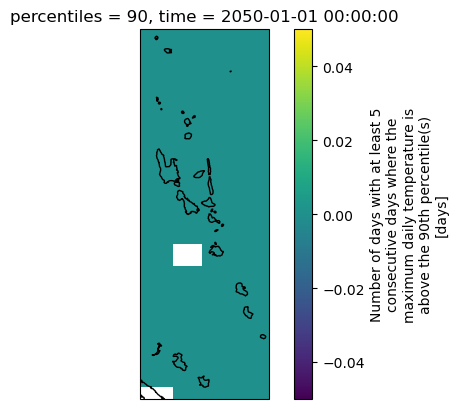

In [13]:
projection = ccrs.epsg(code=3832)  # PDC Mercator
fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw=dict(projection=projection))
vu_mhw_2050.sel(lon=slice(166, 170), lat=slice(-22, -11)).plot.imshow(
    ax=ax, transform=ccrs.PlateCarree()
)
ax.set_extent(extents=[166, 170, -22, -11], crs=ccrs.PlateCarree())
ax.coastlines()

Looks like there might not be so many marine heat waves in
the mid-century period (2050)?

How about for the end of the century (2100)?

In [14]:
with dask.diagnostics.ProgressBar():
    vu_mhw_2100 = da_mhw.sel(time="2100").isel(time=0).compute()

[########################################] | 100% Completed | 92.26 s


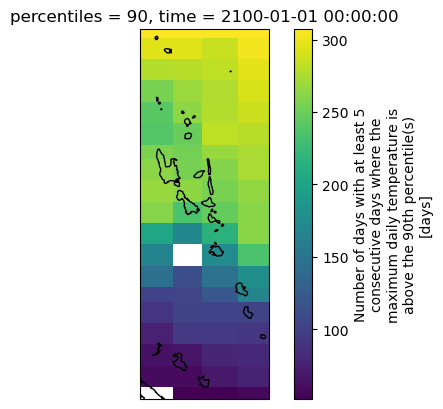

In [15]:
projection = ccrs.epsg(code=3832)  # PDC Mercator
fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw=dict(projection=projection))
vu_mhw_2100.sel(lon=slice(166, 170), lat=slice(-22, -11)).plot.imshow(
    ax=ax, transform=ccrs.PlateCarree()
)
ax.set_extent(extents=[166, 170, -22, -11], crs=ccrs.PlateCarree())
ax.coastlines()

The results appear to match with the report from
https://www.vanclimatefutures.gov.vu/assets/docs/Marine%20Heat%20Waves.pdf
that mentions:

> Under the high emissions scenario (SSP585) this [Marine Heat Wave]
> increases to about 170–310 days per year by 2050,
> with many days in the ‘Strong’ and ‘Severe’ MHW categories

That's all! Hopefully this will get you started on how to handle CMIP6 climate data
for forecasting marine heat waves.